## Configuration Setting & Library

In [1]:
!pip install scikit-fuzzy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import skfuzzy
import numpy as np

## Loading Data

In [3]:
data = pd.read_csv('/kaggle/input/credit-card-customer-data/Credit Card Customer Data.csv')
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


## Data Understanding

In [4]:
data.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Data Preprocessing & Features Engineering

In [7]:
df = data.copy()

In [8]:
features = df.drop(columns = ['Sl_No', 'Customer Key'])
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


### Normalization

In [9]:
mms = MinMaxScaler()
scaled_features = mms.fit_transform(features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_features_df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,0.160275,0.411785,0.480606,0.173737,0.358333
std,0.190992,0.240871,0.326363,0.195715,0.286532
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035533,0.222222,0.200000,0.066667,0.100000
50%,0.076142,0.444444,0.400000,0.133333,0.300000
75%,0.228426,0.555556,0.800000,0.266667,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Building

### Mencari nilai banyak C terbaik

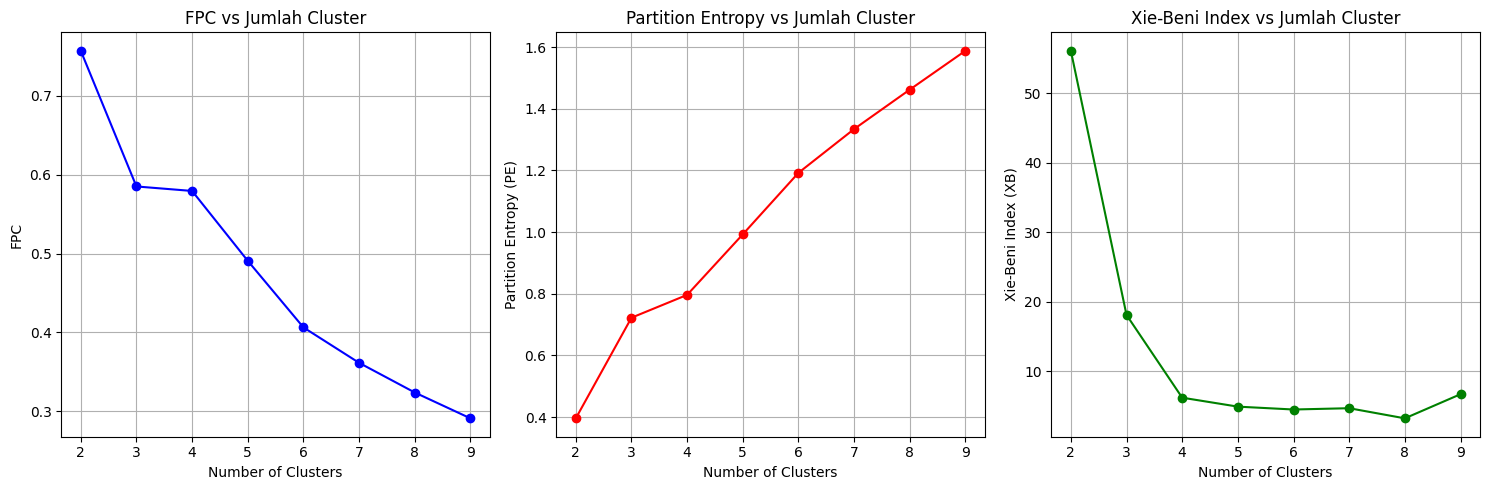

Jumlah cluster terbaik berdasarkan FPC: 2
Jumlah cluster terbaik berdasarkan PE: 2
Jumlah cluster terbaik berdasarkan XB: 8


In [10]:
# Rentang jumlah cluster yang akan diuji
cluster_range = range(2, 10)  # Misal uji untuk 2 hingga 10 cluster
m = 2.0  # Fuzziness parameter

# Variabel untuk menyimpan metrik evaluasi
fpc_values = []
pe_values = []
xb_values = []

# Iterasi untuk setiap jumlah cluster
for c in cluster_range:
    cntr, u, u0, d, jm, p, fpc = skfuzzy.cluster.cmeans(
        scaled_features.T, c=c, m=m, error=0.01, maxiter=1000, init=None
    )
    
    fpc_values.append(fpc)
    
    # Hitung Partition Entropy (PE)
    pe = -np.sum(u * np.log(u)) / scaled_features.shape[0]
    pe_values.append(pe)

    # Hitung Xie-Beni Index (XB)
    cluster_distances = np.linalg.norm(scaled_features[:, np.newaxis, :] - cntr, axis=2)**2
    min_distances = np.min(cluster_distances, axis=1)
    xb = np.sum(np.sum(u**2, axis=0) * min_distances) / (scaled_features.shape[0] * np.min(cluster_distances))
    xb_values.append(xb)

# Tentukan jumlah cluster terbaik untuk setiap metrik
optimal_fpc = cluster_range[np.argmax(fpc_values)]
optimal_pe = cluster_range[np.argmin(pe_values)]
optimal_xb = cluster_range[np.argmin(xb_values)]

# Visualisasi hasil
plt.figure(figsize=(15, 5))

# Plot FPC
plt.subplot(1, 3, 1)
plt.plot(cluster_range, fpc_values, marker='o', linestyle='-', color='b')
plt.title("FPC vs Jumlah Cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("FPC")
plt.grid(True)

# Plot PE
plt.subplot(1, 3, 2)
plt.plot(cluster_range, pe_values, marker='o', linestyle='-', color='r')
plt.title("Partition Entropy vs Jumlah Cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("Partition Entropy (PE)")
plt.grid(True)

# Plot XB
plt.subplot(1, 3, 3)
plt.plot(cluster_range, xb_values, marker='o', linestyle='-', color='g')
plt.title("Xie-Beni Index vs Jumlah Cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("Xie-Beni Index (XB)")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Jumlah cluster terbaik berdasarkan FPC: {optimal_fpc}")
print(f"Jumlah cluster terbaik berdasarkan PE: {optimal_pe}")
print(f"Jumlah cluster terbaik berdasarkan XB: {optimal_xb}")

## Clustering

In [11]:
optimal_c = 2

In [12]:
cntr, u, u0, d, jm, p, fpc = skfuzzy.cluster.cmeans(
    scaled_features_df.T, c=optimal_c, m=2, error=0.005, maxiter=1000, init=None
)

## Reduksi Dimensi dengan PCA untuk visualisasi

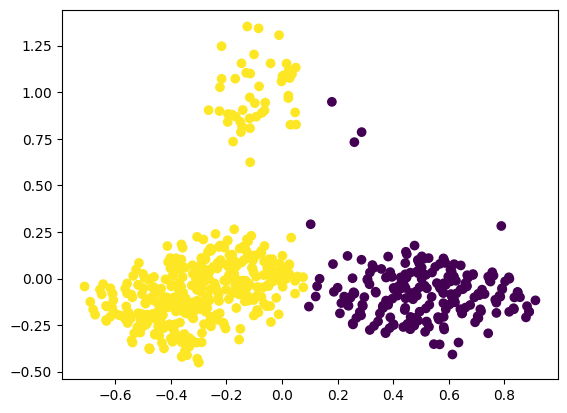

In [13]:
# 2. PCA untuk Reduksi Dimensi
pca = PCA(n_components=3)
data_2d = pca.fit_transform(scaled_features_df)

# Visualisasikan hasil clustering
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=np.argmax(u, axis=0))
plt.show()

In [14]:
print(f"Final Partition Coefficient: {fpc}")

Final Partition Coefficient: 0.7572242197439782
